In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from astropy.io import fits
import pandas
from spectral_cube import SpectralCube
import plotly.express as px
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel

import warnings
warnings.filterwarnings('ignore')

In [2]:
Cube = SpectralCube.read('/home/scratch/hfwest/RAMPS/Data/L28_5_NH3_1-1_cube.fits') # Bring in spectral cube to obtain longitude, latitude, and V_LSR values from pixel values
v, y, x = Cube.world[:, :, :] # Extract wcs
x_eff = x / u.deg # Remove units
y_eff = y / u.deg
v_eff = v / (u.km/u.s)

In [3]:
RAMPS_data = pandas.read_csv('/users/hfwest/GBO-REU/Data/RAMPS_clump_catalog_diss_data.txt', sep = '\s+')
RAMPS_data['l'] = np.zeros(shape=len(RAMPS_data)) # Create 'l' and 'b' columns
RAMPS_data['l'][0] = '(deg)'
RAMPS_data['b'] = np.zeros(shape=len(RAMPS_data))
RAMPS_data['b'][0] = '(deg)'
RAMPS_data['T_peak'] = np.zeros(shape=len(RAMPS_data))
RAMPS_data['T_peak'][0] = '(K)'

for idx in range(1, len(RAMPS_data)): # For each item, extract longitude and latitude from clump name
    RAMPS_data.at[idx,'l'] = float(RAMPS_data.at[idx, 'ClumpName'][1:7])
    RAMPS_data.at[idx, 'b'] = float(RAMPS_data.at[idx, 'ClumpName'][7::]) # includes sign at index 7

    l_val = float(RAMPS_data.at[idx, 'l'])
    b_val = float(RAMPS_data.at[idx, 'b'])
    sky = SkyCoord(l=l_val, b=b_val, unit='deg', frame='galactic')
    y_pix, x_pix = skycoord_to_pixel(sky, Cube.wcs.celestial)
    x_pix = int(x_pix)
    y_pix = int(y_pix)
    if 0 <= x_pix < Cube.shape[2] and 0 <= y_pix < Cube.shape[1]:
        spectrum = Cube[:, y_pix, x_pix].value
        # Get the V_LSR value for this row and convert to float
        v_lsr = float(RAMPS_data.at[idx, 'V_LSR'])
        # Get the velocity axis for this pixel (in km/s)
        vel_axis = Cube.spectral_axis.to(u.km/u.s).value
        # Find indices within 10 km/s of v_lsr
        mask_v = np.abs(vel_axis - v_lsr) <= 10
        RAMPS_data.at[idx, 'T_peak'] = float(np.max(spectrum[mask_v]))
    else:
        RAMPS_data.at[idx, 'T_peak'] = np.nan

# Then remove extraneous columns, including the original clump name
RAMPS_data = RAMPS_data.drop(columns=['ClumpName', 'T_rot', 'log10(N_tot,ba)', 'p1', 'M_clump', 'L_clump', 'EvolState', 
                         'FILLER', 'FILLER.1', 'FILLER.2', 'T_rot_err','log10(N_tot,ba)_err', 'sigma_err', 
                         'V_LSR_err', 'chi(NH3)_err', 'd1_err', 'FILLER.3', 'M_clump_err', 'L_clump_err', 'FILLER.4'])

In [4]:
RAMPS_data

,theta_maj,theta_min,sigma,V_LSR,chi(NH3),d1,l,b,T_peak
0,(arcmin),(arcmin),(km/s),(km/s),(unitless),(kpc),(deg),(deg),(K)
1,1.7091411264505836,0.9846699238195086,0.314694522311,5.2894819608,NaN,4.8,9.612,0.142,NaN
2,3.805428054363068,2.402000572584829,0.83105567403,4.28876439395,3.58206552488e-08,4.8,9.623,0.191,NaN
3,1.0624365856111189,0.8490050974098039,0.333130734574,2.70899364263,NaN,3.86,9.629,0.266,NaN
4,0.905427652250561,0.7072311175166667,0.224414712996,22.4674223611,NaN,2.81,9.634,0.298,NaN
...,...,...,...,...,...,...,...,...,...
2676,4.052036432863452,0.9481792718128992,0.861155851189,56.2743968352,NaN,4.17,47.044,0.248,NaN
2677,1.7010196911251547,0.923016748643936,0.420704288902,58.449039996,NaN,4.24,47.141,0.319,NaN
2678,2.917814832089954,0.7275766000103534,0.764417439979,58.0328150138,NaN,4.27,47.171,0.313,NaN
2679,0.9988994922785079,0.5005601272218272,0.633378861293,58.3624671728,NaN,4.26,47.223,0.318,NaN


In [5]:
clipped_RAMPS_data = RAMPS_data[RAMPS_data['T_peak'].astype('str') != str(np.nan)]
print(len(clipped_RAMPS_data))
clipped_RAMPS_data

152


,theta_maj,theta_min,sigma,V_LSR,chi(NH3),d1,l,b,T_peak
0,(arcmin),(arcmin),(km/s),(km/s),(unitless),(kpc),(deg),(deg),(K)
1596,1.979618870515162,0.42432750523333335,0.599715629413,72.5131737327,NaN,4.3,28.143,0.197,0.347842
1598,1.5232928199643105,1.0769447243144081,0.543403162683,89.890206967,2.82794484246e-08,4.51,28.153,0.17,0.281333
1601,0.8601693230543593,0.5657309390867248,0.359489545306,92.4329461814,NaN,8.26,28.158,0.108,0.305213
1602,0.8485744806667175,0.4242410045233333,0.83094923281,77.1915789138,NaN,4.32,28.172,0.075,0.408492
...,...,...,...,...,...,...,...,...,...
1747,2.061626765975521,0.8245930750642585,0.335369011192,52.7970654486,NaN,10.73,28.873,0.086,0.213026
1748,0.8944732812864551,0.6324314818969822,0.31731477341,94.4044770052,NaN,4.71,28.875,0.076,0.175889
1749,1.941661490727564,1.216545056315589,0.593673496843,101.454029753,3.48624881368e-08,8.04,28.886,-0.022,0.362392
1750,3.5842155952803014,1.2084830095486718,0.717282139295,96.3864806183,1.68680350786e-08,8.02,28.922,-0.229,0.119981


In [6]:
_28_5_data = pandas.read_csv('/users/hfwest/GBO-REU/Data/RAMPS_CLF/28_5.txt', sep = '\s+')
_28_5_data['l'] = np.zeros(shape=len(_28_5_data))
_28_5_data['b'] = np.zeros(shape=len(_28_5_data))
_28_5_data['V_LSR'] = np.zeros(shape=len(_28_5_data))

for idx in range(len(_28_5_data)): # For each clump found, convert pixel value to real value:
    _28_5_data.at[idx, 'l'] = x_eff[_28_5_data.at[idx, 'v'], _28_5_data.at[idx, 'y'], _28_5_data.at[idx, 'x']]
    _28_5_data.at[idx, 'b'] = y_eff[_28_5_data.at[idx, 'v'], _28_5_data.at[idx, 'y'], _28_5_data.at[idx, 'x']]
    _28_5_data.at[idx, 'V_LSR'] = v_eff[_28_5_data.at[idx, 'v'], _28_5_data.at[idx, 'y'], _28_5_data.at[idx, 'x']]

_28_5_data = _28_5_data.drop(columns= ['Ncl', 'x', 'y', 'v', 'FWHMx', 'FWHMy', 'FWHMv', 'Npix']) # Remove extraneous columns including original pixel values


In [7]:
_28_5_data

,Tpeak,R,Sum(T),l,b,V_LSR
0,3.58,7.92,2371.11,28.202502,-0.045833,95.806555
1,3.55,8.02,2249.01,28.569212,-0.239167,87.839274
2,3.51,8.00,2465.62,28.200835,-0.050833,96.005737
3,3.35,12.89,4170.72,28.564210,-0.234167,85.648271
4,3.30,8.50,2038.34,28.205834,0.017500,78.278536
...,...,...,...,...,...,...
576,0.29,0.56,1.25,28.819249,-0.315833,101.582833
577,0.28,0.56,2.48,28.897546,-0.234167,95.408191
578,0.28,0.56,2.81,28.650844,0.112500,64.933341
579,0.27,0.56,1.99,28.814208,-0.222500,98.395921


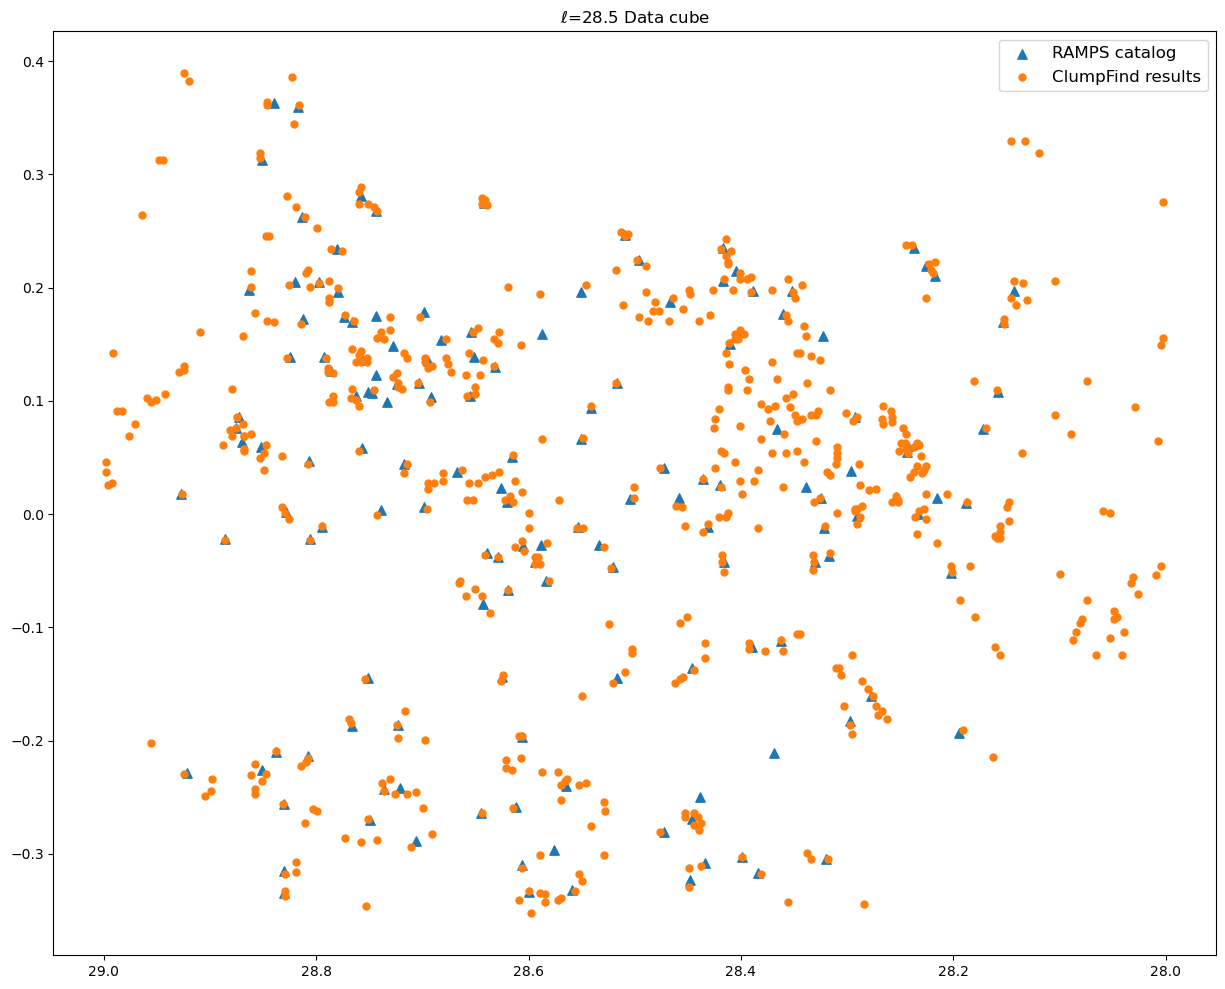

In [8]:
clf_mask = _28_5_data['Tpeak'] >= min(clipped_RAMPS_data['T_peak'][1::])

# Original catalog mask: entries within pixel bounds of data cube
# ClumpFit result mask: Peak temperature of clump is higher than lowest clump T_peak in original catalog

plt.figure(figsize= (15, 12))

# For size based on theta_maj:
# plt.scatter(clipped_RAMPS_data['l'][1::], clipped_RAMPS_data['b'][1::], marker='^', s=np.array(clipped_RAMPS_data['theta_maj'][1::].astype('float64'))*40, label= 'RAMPS catalog')

plt.scatter(clipped_RAMPS_data['l'][1::], clipped_RAMPS_data['b'][1::], marker='^', s= 45, label= 'RAMPS catalog')
plt.scatter(_28_5_data['l'][clf_mask], _28_5_data['b'][clf_mask], s=25, label= 'ClumpFind results')

plt.title('$\ell$=28.5 Data cube')
plt.legend(fontsize='large')
plt.gca().invert_xaxis()
plt.show()